# Estimating the SCC using CIL damage functions and the FAIR SCM

This notebook builds on the [FAIR example notebook](./Example-Usage.ipynb) and adds an SCC simulation using damage functions from the Climate Impact Lab's mortality work.

The experiment is conducted as follows:

* Use the RCP scenarios as defined by the default FAIR model
* Add an additional CO2 impulse (1 Gt C) to each trajectory in 2020
* Compute damages using the resulting temperature trajectories
* Subtract the damages in the standard RCPs from the damages in the pulse runs
* Divide this value by the quantity of added CO2 (1 Gt C * 44.0098 / 12.011 = 3.66 Gt CO2) to achieve \$/ton CO2
* Compute the NPV of this time series of marginal damages using various discount rates

All of this work and the source data can be found in the Climate Impact Lab's [FAIR-SCM repo](https://gitlab.com/ClimateImpactLab/Climate/FAIR-SCM) on gitlab.

Version 0.3 update 6/22/18:
Version 0.3 updates the damages calculation to take the linear extrapolation of the quadratic damage function for post-2099 periods as one alternative, or to hold the damage function constant at 2099 values for another alternative, and output both results. In addition, it is formatted to accept multiple scenarios within a given damage function .csv file, and select one of them for analysis and output.

Update 10/4/18: Updated the FAIR temperature anomaly from 0.8C to 0.6C per Bob's instructions.

## Set up workspace

In [1]:
%matplotlib inline

In [2]:
! pip install fair==1.3.2

In [3]:
import sys
sys.path.append('..')

import fair
fair.__version__

'1.3.2'

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import getpass

user = getpass.getuser()

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

# from scc import load_fair
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
import seaborn as sns
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize'] = (16, 9)

from datetime import datetime

import sys
sys.path.append('./functions/.')
import load_fair

/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [5]:
# Make this labor specific

model = "poly4_below0bin"
df = "quadratic"
clim_data = "GMFD"
ssp = 3        #change here for different SSP
#grp_test = "semi-parametric"
OUTPUT_path = "/home/{}/repos/labor-code-release-2020/output/damage_function_no_cons/SSP{}/non_ce".format(user, ssp)
INPUT_path = "/home/{}/repos/labor-code-release-2020/output/damage_function_no_cons/SSP{}".format(user, ssp)

/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


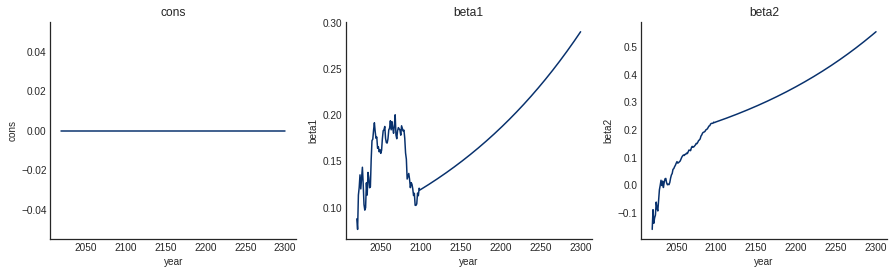

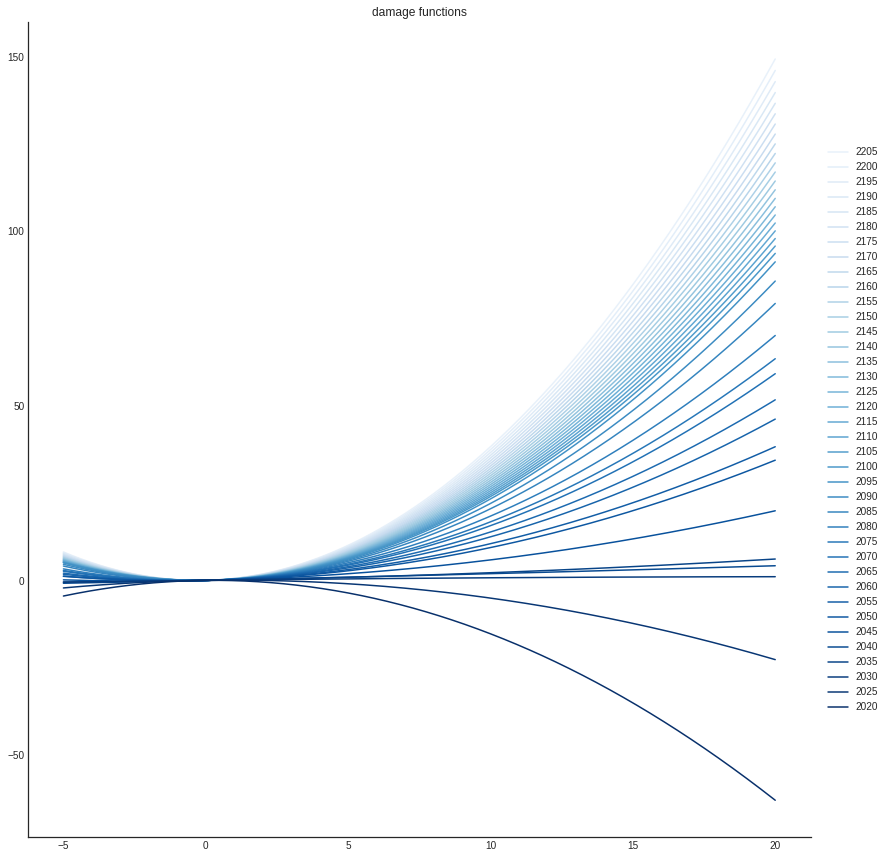

In [40]:

version = 'v0.3'

# change stuff here #
specification = 'labor_main_model'

stem = "nocons_betas_SSP{}".format(ssp)

#######################

MAGNITUDE_OF_DAMAGES = 1000000000000  # magnitude of damage function values
DAMAGES_DEFLATOR = 90.8776 # Damages based year is 2005, with this World Bank US GDP deflator
PULSE_DEFLATOR = 108.6850 # Update for the pulse base year (currently 2020) -- use the World Bank US GDP deflator for that year.
BASE_YEAR_CONVERSION = 1
# PULSE_DEFLATOR / DAMAGES_DEFLATOR  # Converts from Damages_year $ to Pulse_year $

# Toggle to generate plots or not
generate_plots = True

# Run options: which damages scenario to run, and whether or not to hold the post-2099 damage function constant.
# scenario_to_run = 'peakprice014'  # 'price0', 'price014', 'price03', 'price05', 'peakprice014'
hold_2099_damages_fixed = False
damage_func_form = df # 'quadratic' or 'cubic'

import os, glob

# Time the SCC calculation
startTime = datetime.now()

# Make sure the 'year' and 'growth_rate' columns are the first two columns in the damage function .csv
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))


def read_damage_func(fp):
    data = pd.read_csv(fps[0], index_col = [0]) 
    data = data[["cons","beta1","beta2"]]
    data.columns.names = ['coeff']
    return data.stack('coeff').to_xarray()

ds = xr.Dataset({
    os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp) for fp in fps
})
# data['cons'].values[:] = 0


# The placeholder dimension is not used. The line .sel(placeholder='ss') will get rid of it.

####### Change stuff here to deal with placeholders
coeffs_all_years = (
    ds.to_array(dim='variable').to_series().unstack('year')
    .reindex(list(range(2020, 2301)), axis=1)
    .stack('year')
    .unstack('coeff')
    .to_xarray()
)
###########################

# The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
# I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
if hold_2099_damages_fixed:
    mask = coeffs_all_years['year'] > 2099
    coeffs_2099 = coeffs_all_years.sel(year=2099)
    coeffs_all_years = xr.where(mask, coeffs_2099, coeffs_all_years)
    
    
coeffs_all_years = coeffs_all_years.sel(variable=stem)
# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, coeff in enumerate(['cons', 'beta1', 'beta2']):
        lines = coeffs_all_years[coeff].plot.line(
            x='year', ax=axes[i], add_legend=False, 
            color=matplotlib.cm.Blues_r(1) )
        axes[i].set_title(coeff)

    sns.despine()
    
powers = xr.DataArray(
        np.arange(0, 11),
        dims=['coeff'],
        coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

# Potential change spot!!!!
# Growth_rate is the energy price scenario -- change for given sector's needs

if generate_plots:
    temps = np.linspace(-5, 20, 1101)
    temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

    numvars = 1
    fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

    if numvars == 1:
        axes = np.array([[axes]])

    # dot product of coeffs and powers of temp
    spaghetti = (
        (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

    lines = []
    for y in reversed(coeffs_all_years.year.values[:186:5]):
        lines.append(
            axes[0,0].plot(
                temps.values,
                spaghetti.sel(year=y).values,
                color=matplotlib.cm.Blues_r((y-2020.0)/(2200-2000)),
                label=int(y)))

    axes[0,0].set_facecolor('white')
    axes[0,0].set_title("damage functions")

    plt.subplots_adjust(right=0.85)
    axes[0, -1].legend(
        list(reversed(lines))[::5],
        labels=list(reversed(coeffs_all_years.year.values[:186]))[::5],
        loc='center left',
        bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
    fig.set_facecolor('white')

    sns.despine()
    fig.savefig('{}/damage_functions_{}_{}_{}_2200-fixed-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2099_damages_fixed))
    

## Check quantile regression coefficients

/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.7/site-packages/ipykernel_launcher.py:120: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
/home/liruixue/miniconda3/envs/risingverse/lib/python3.

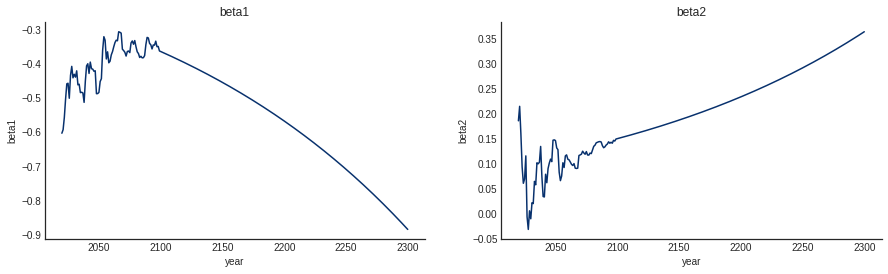

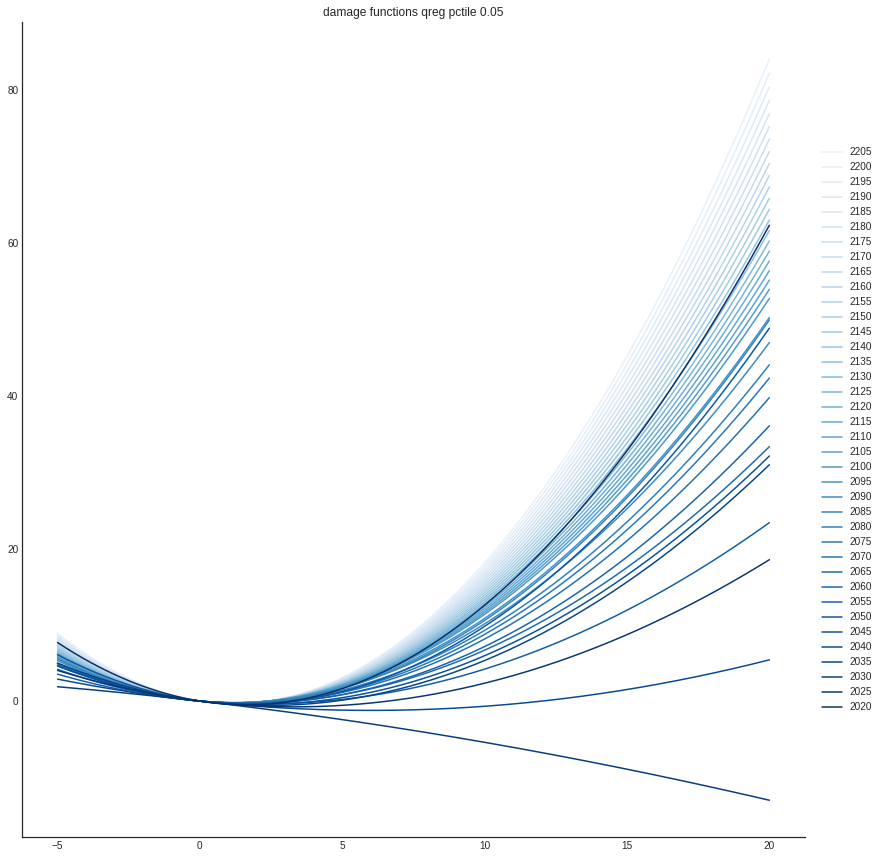

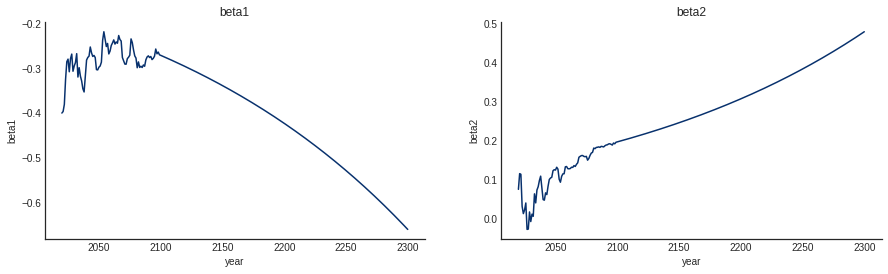

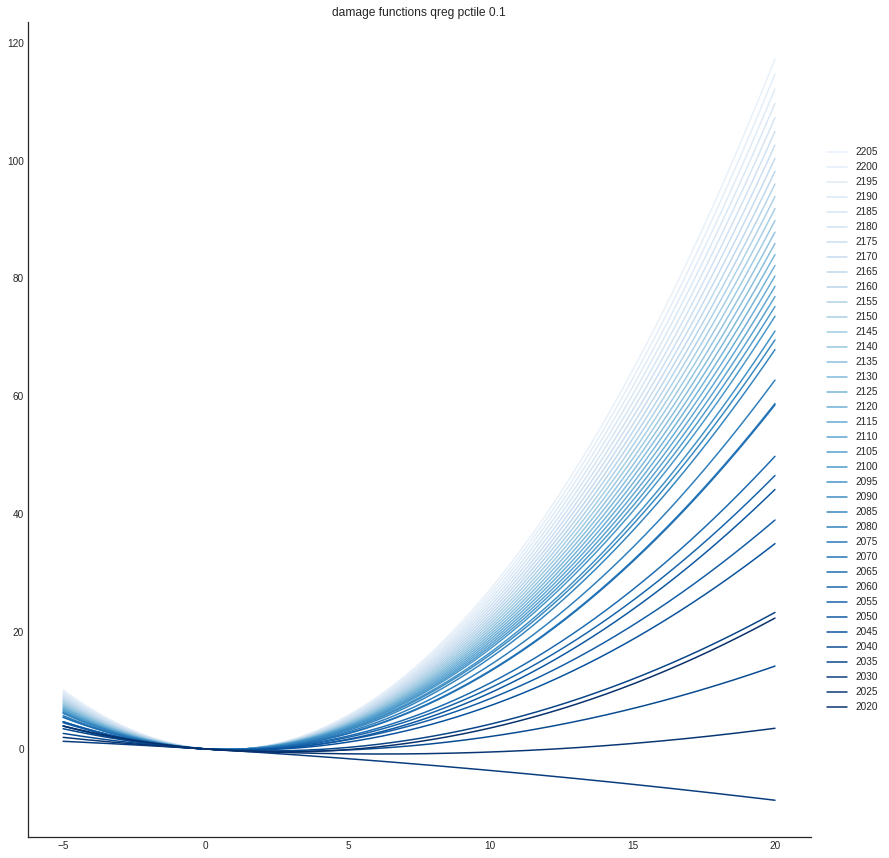

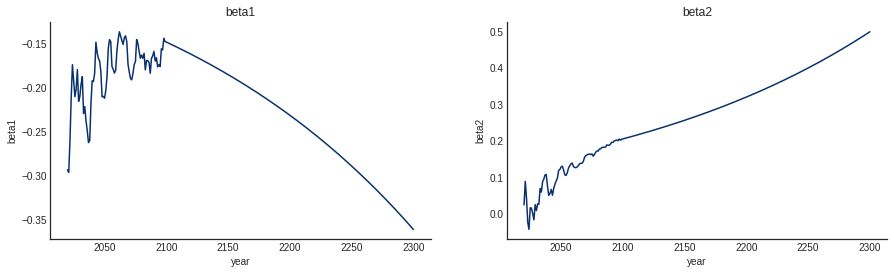

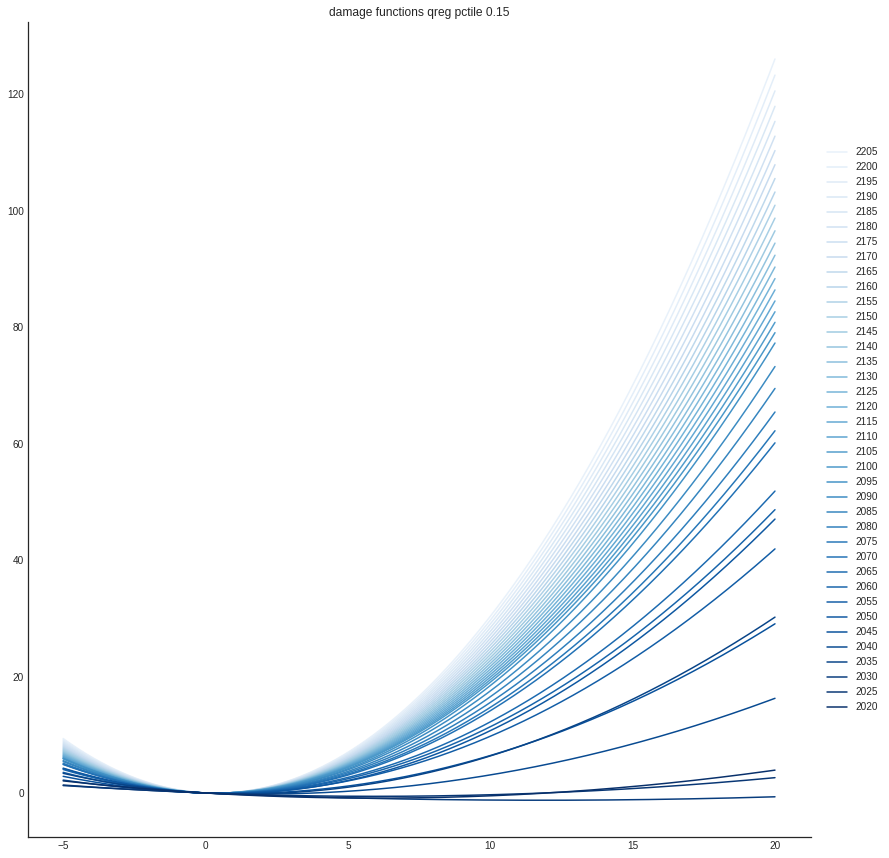

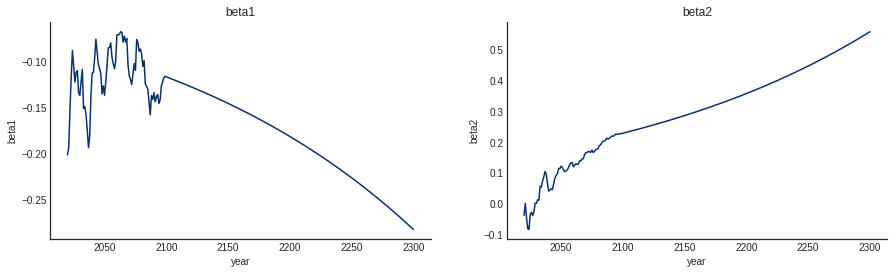

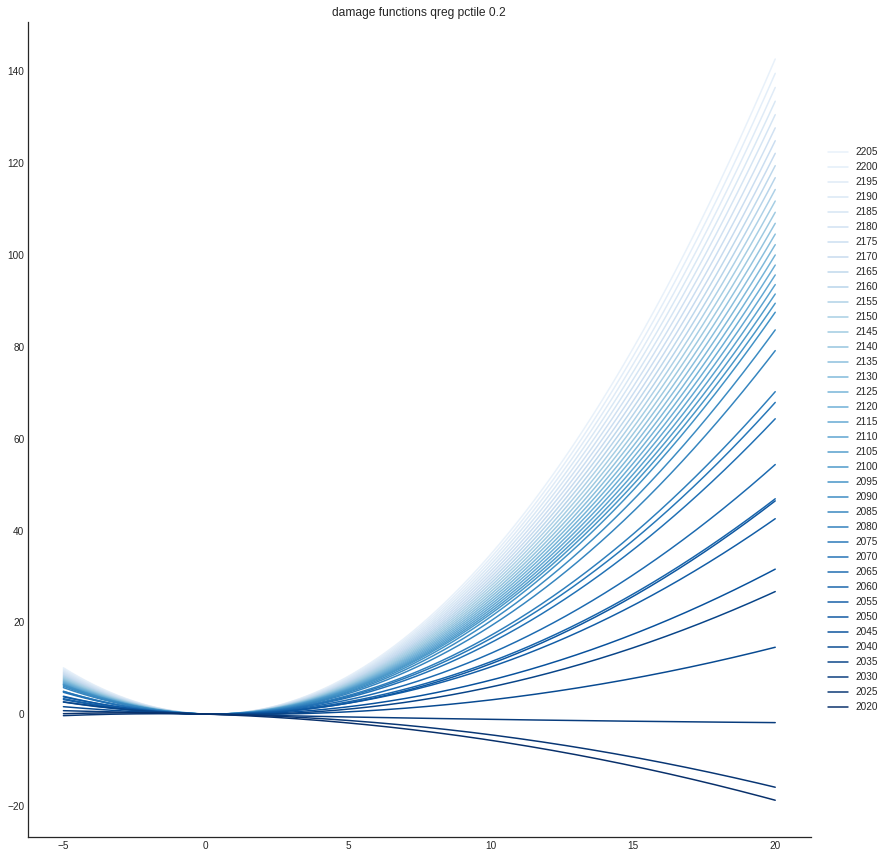

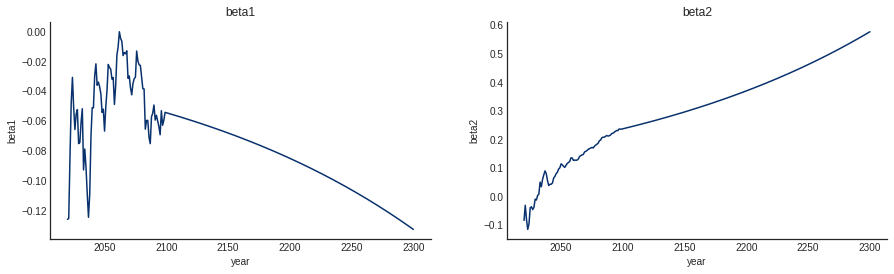

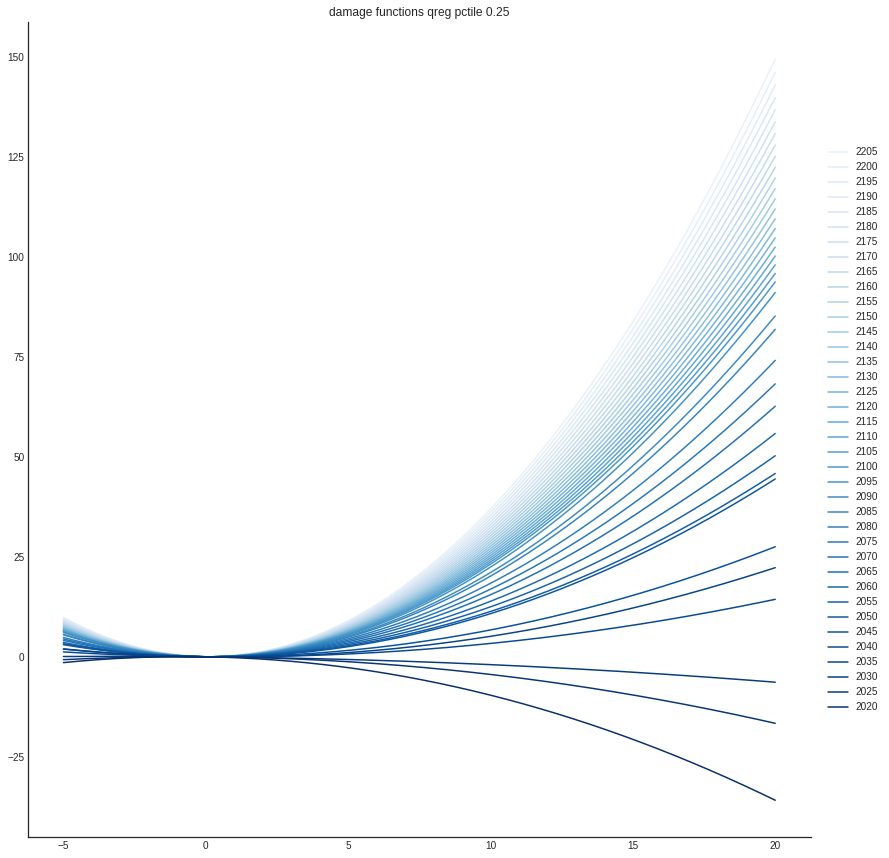

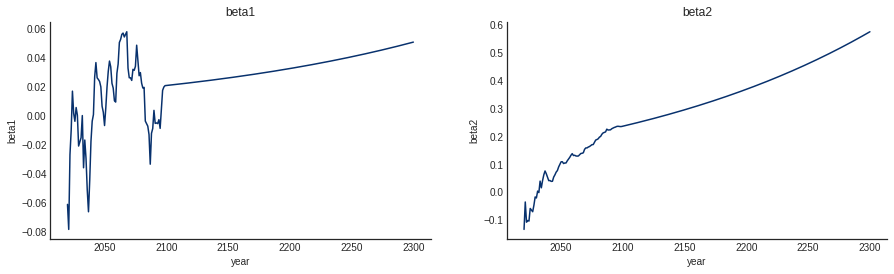

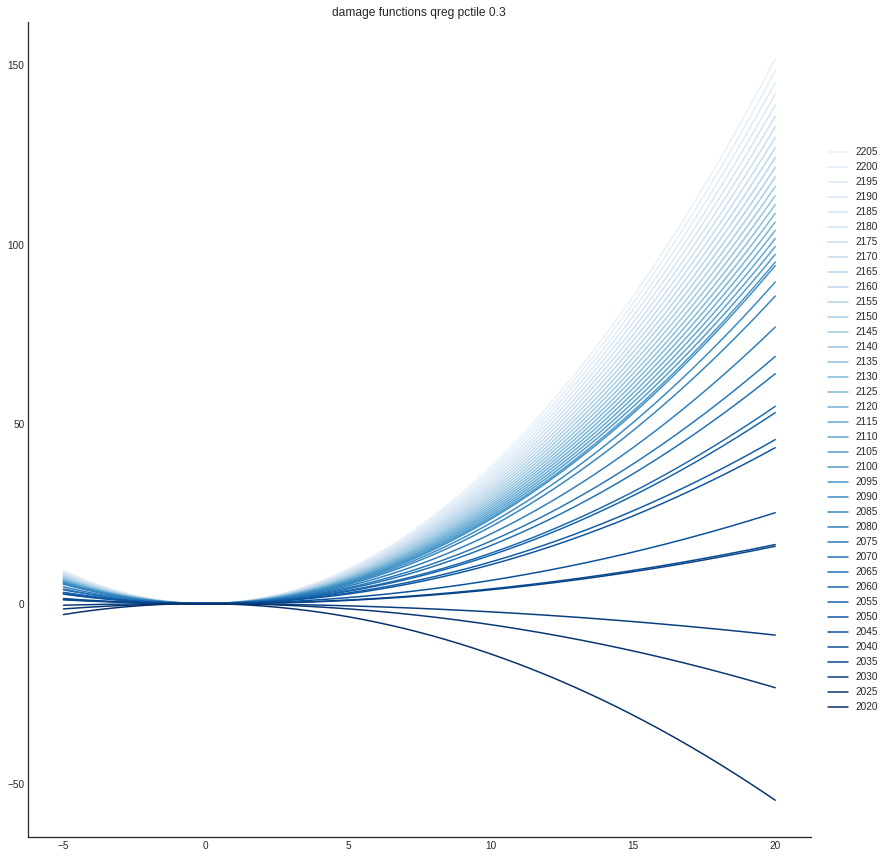

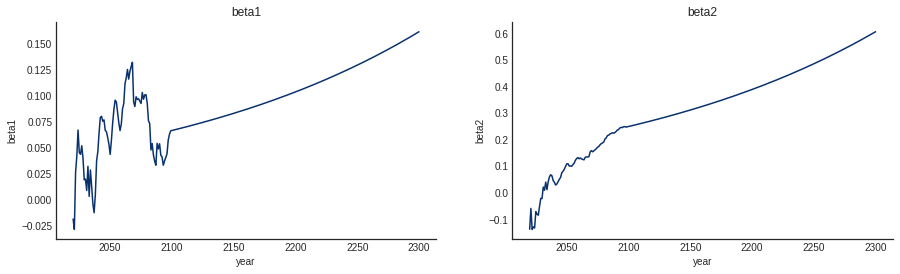

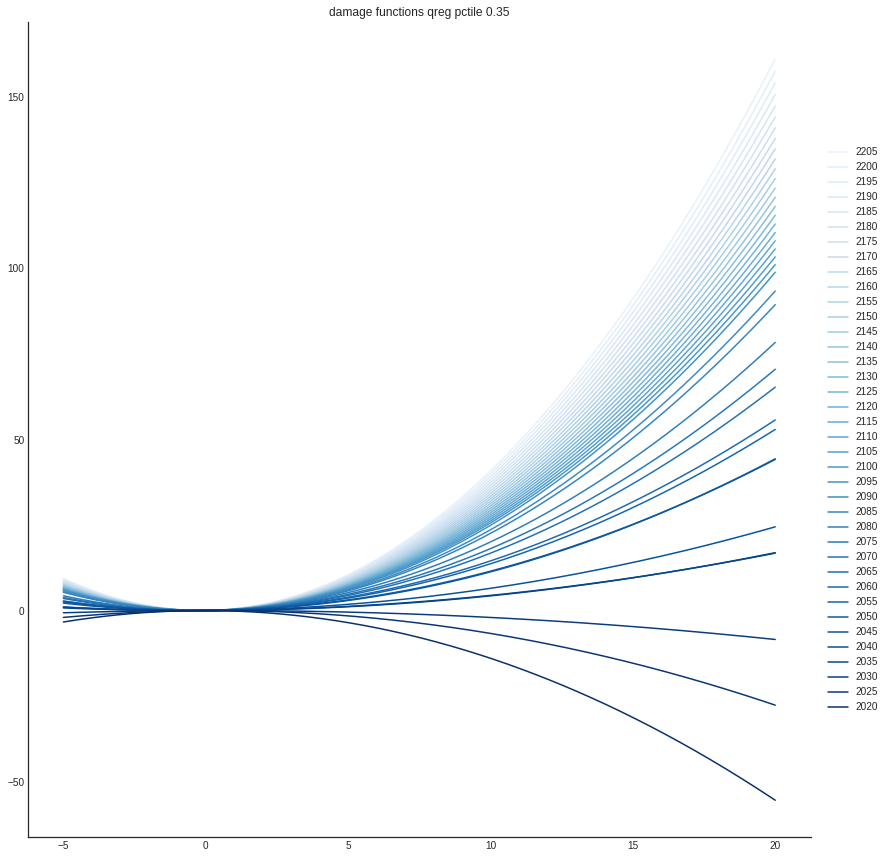

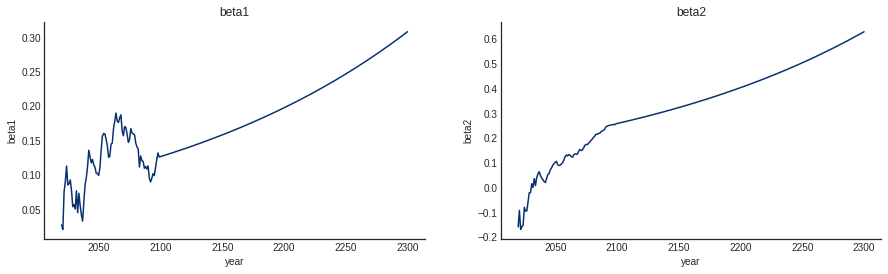

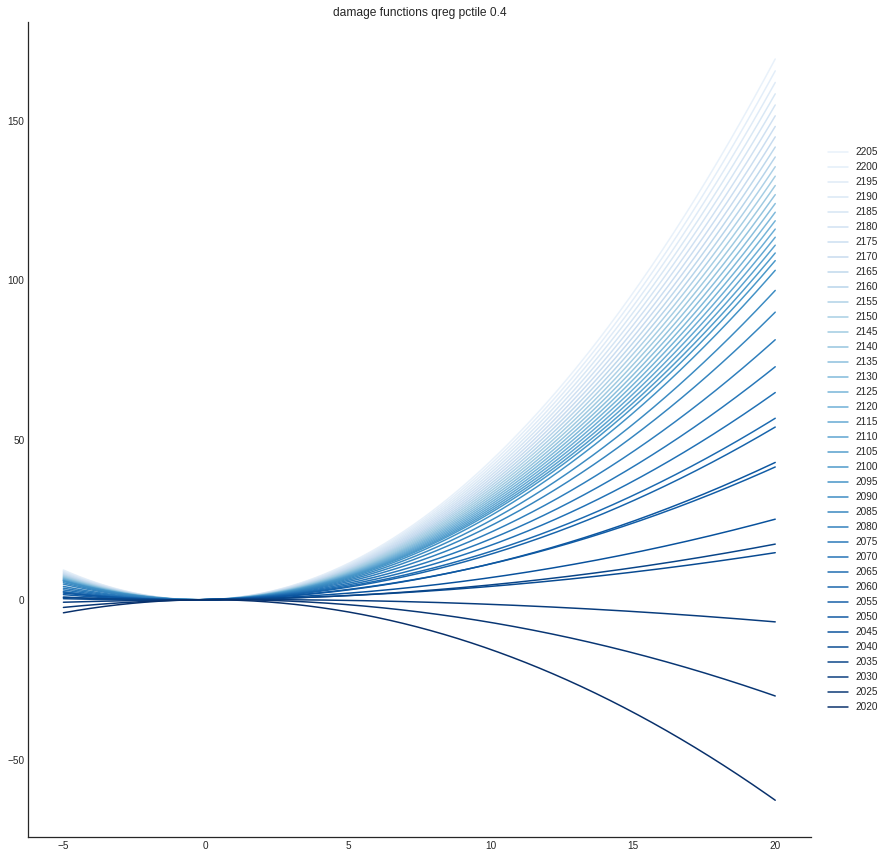

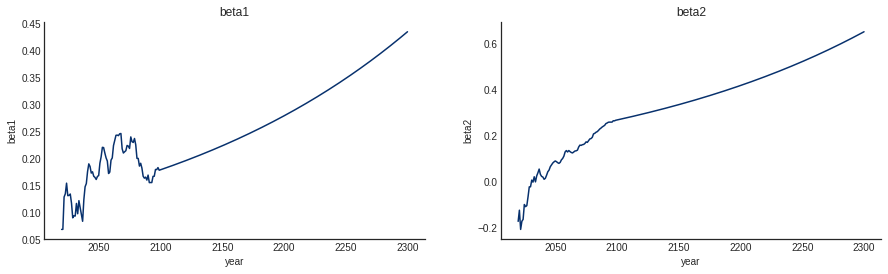

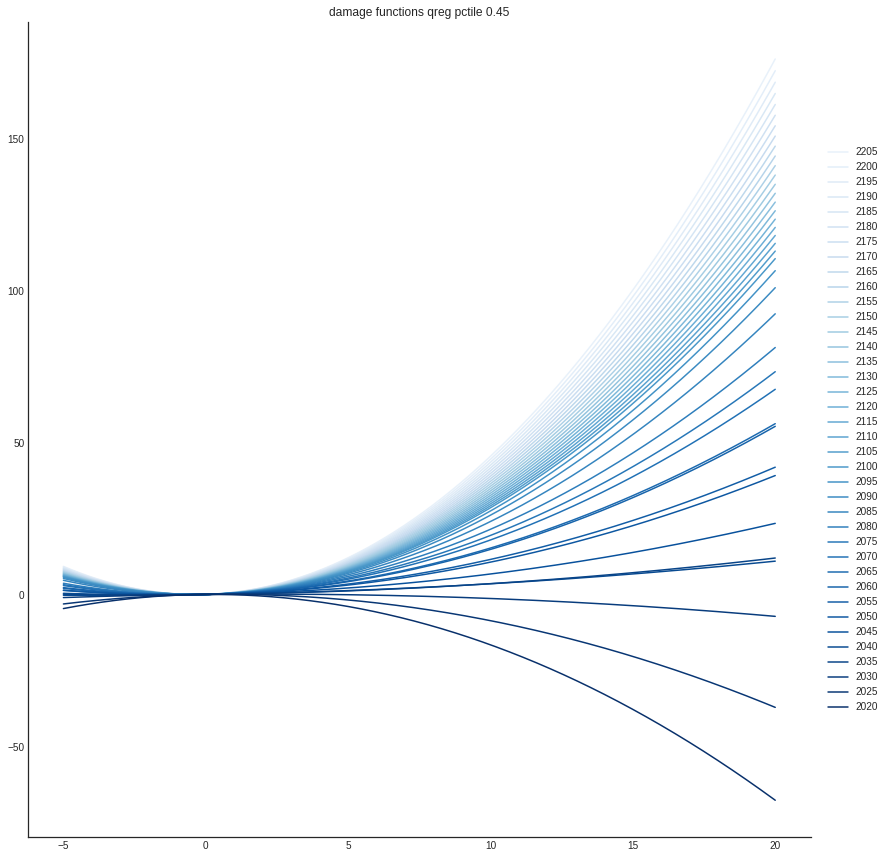

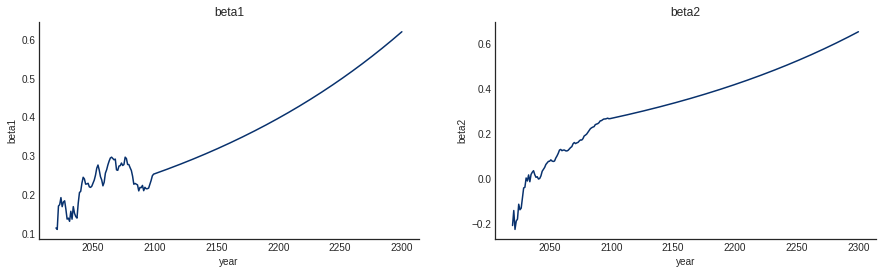

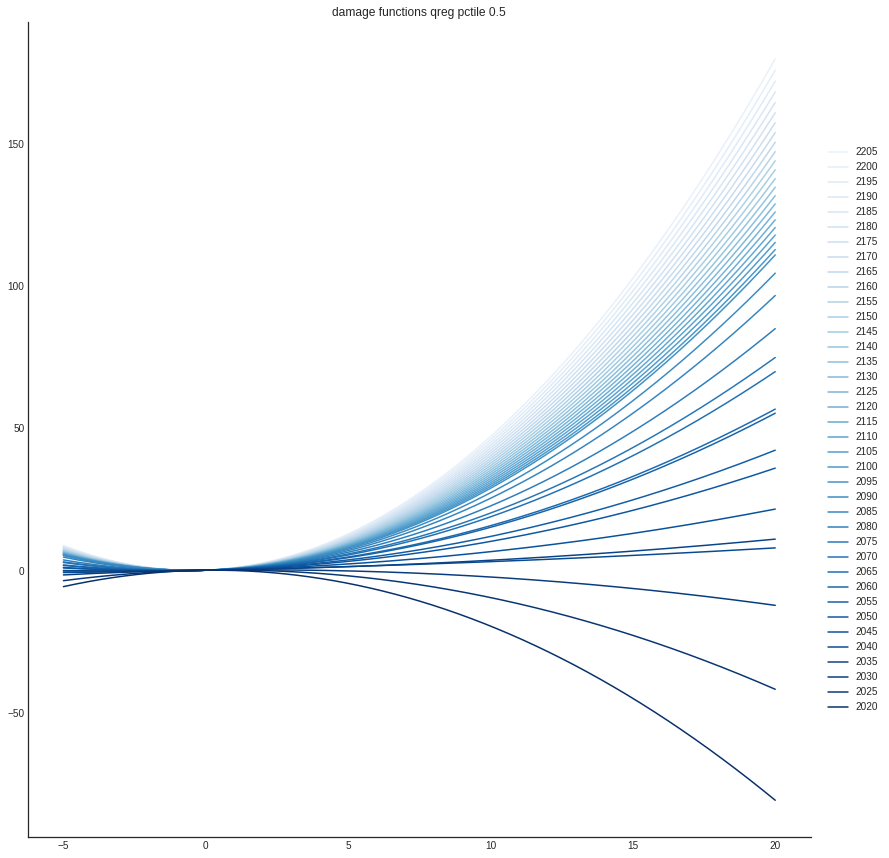

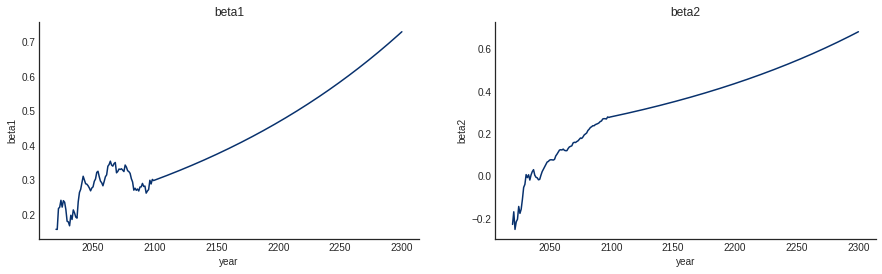

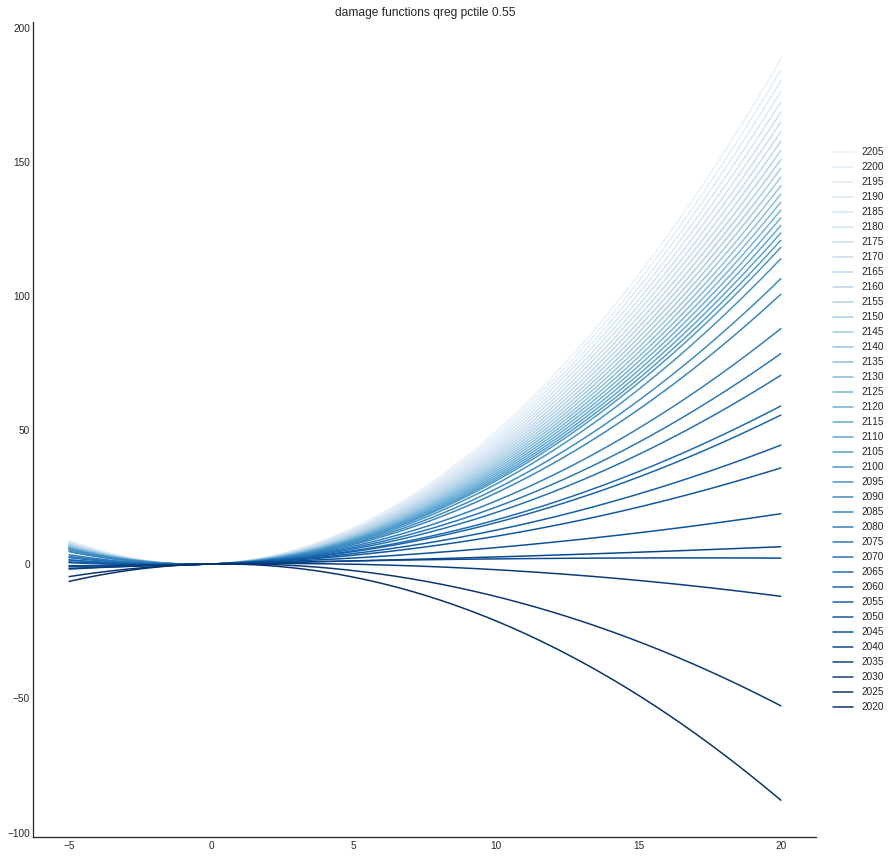

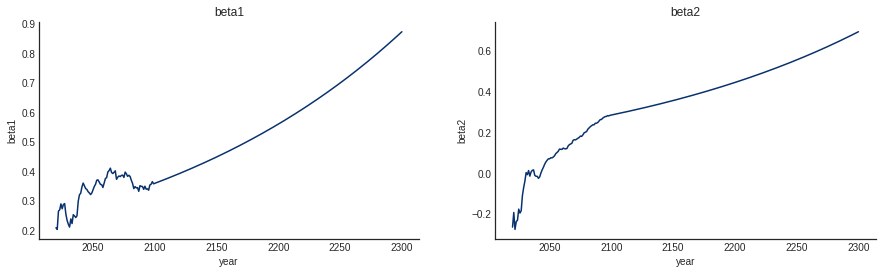

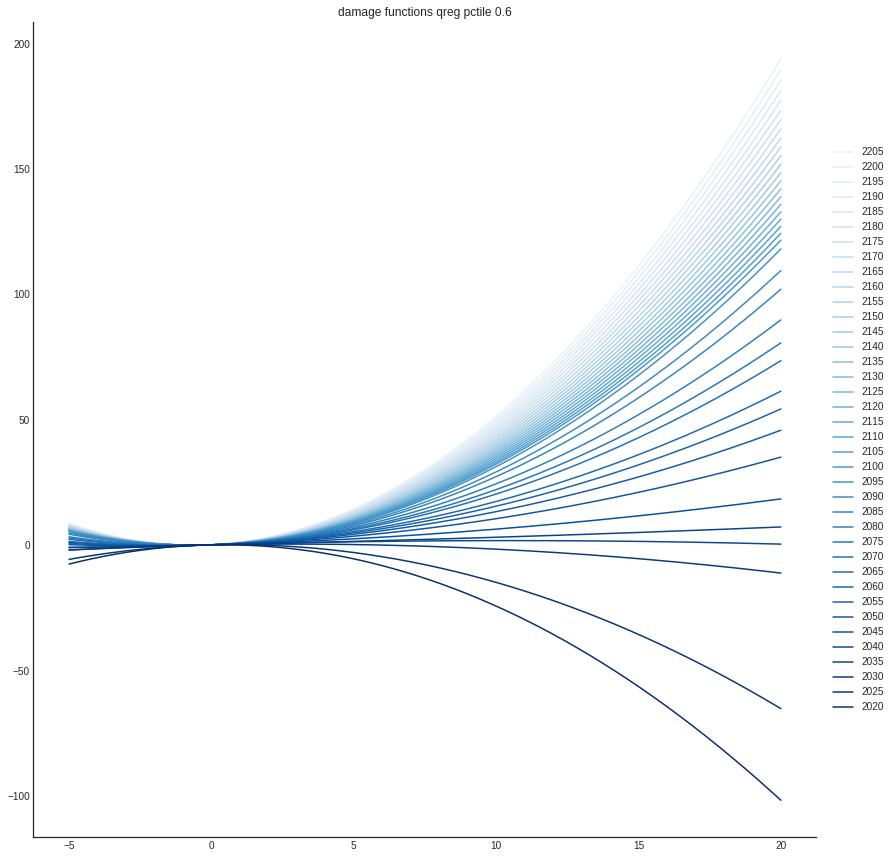

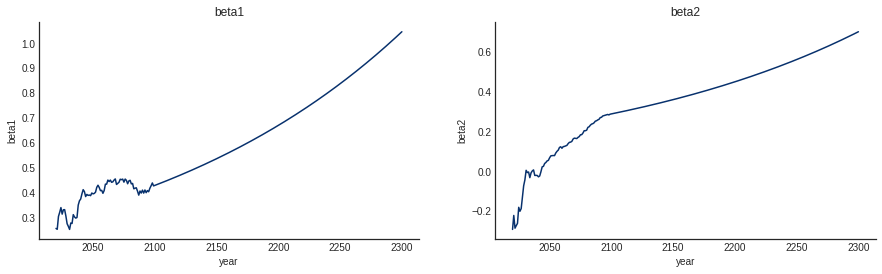

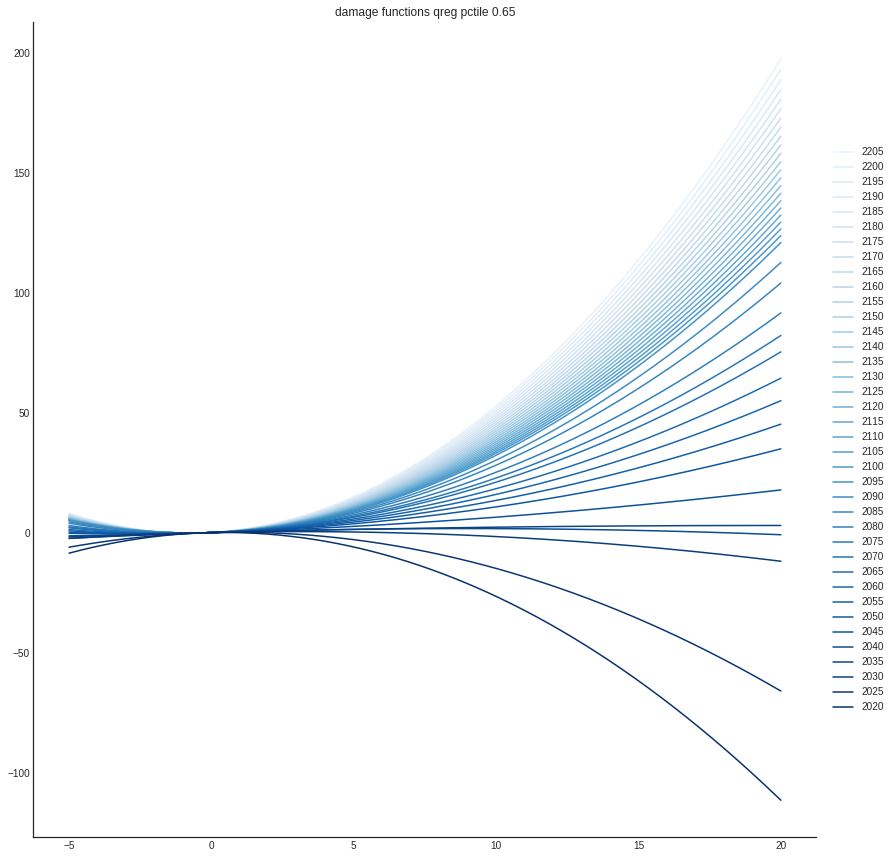

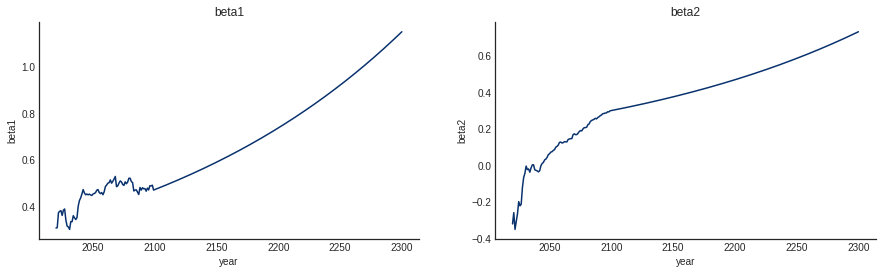

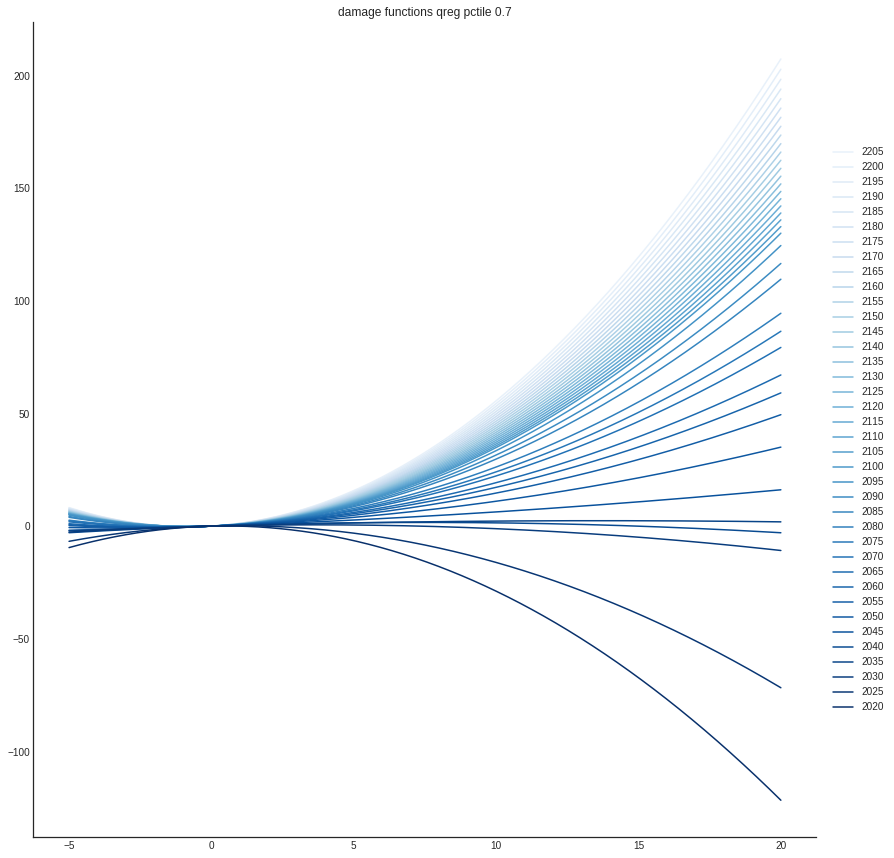

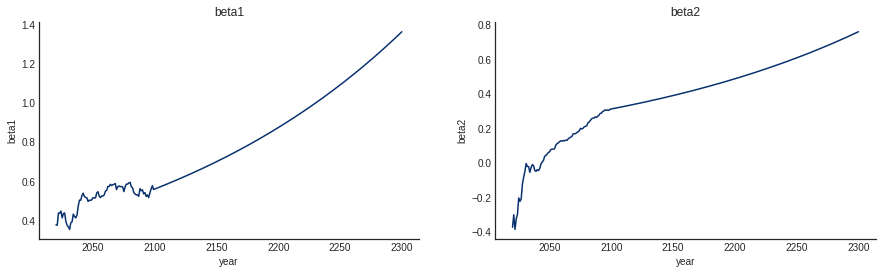

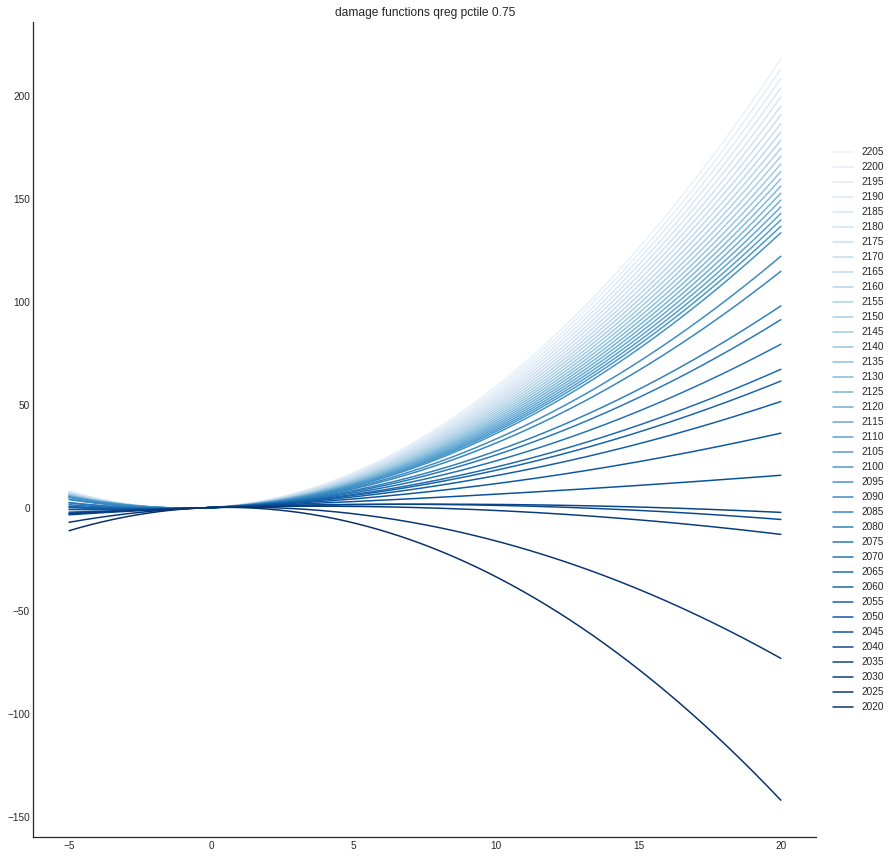

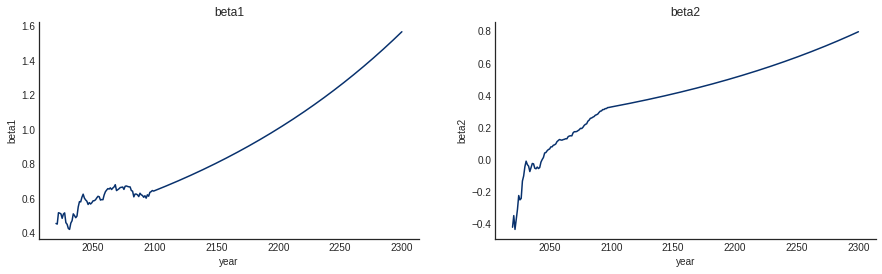

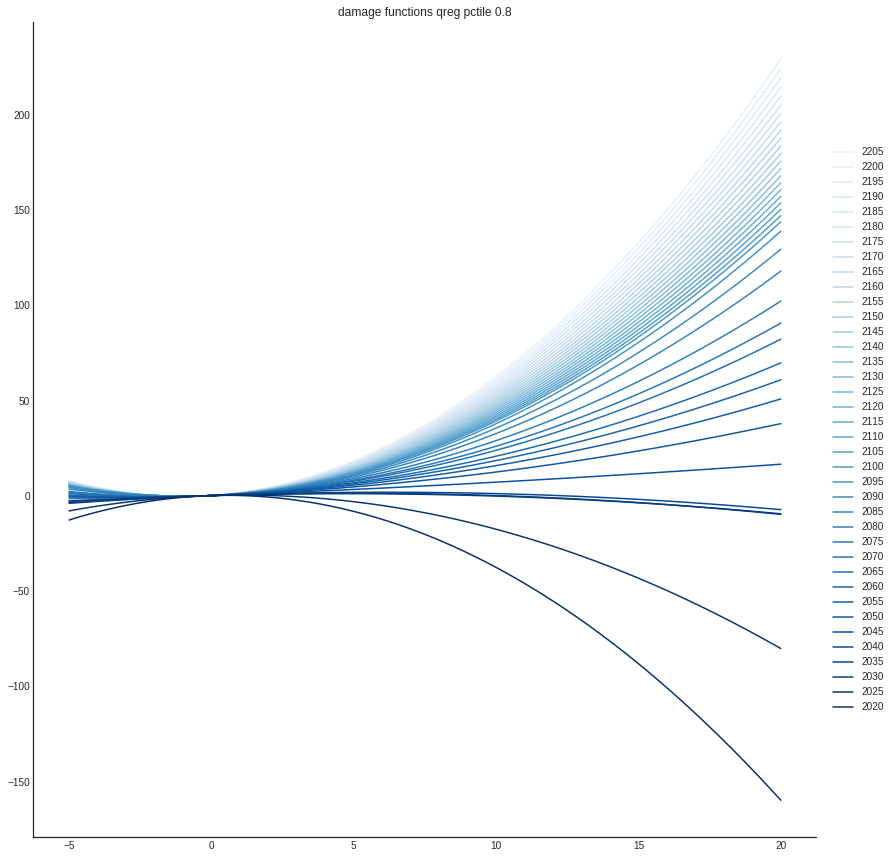

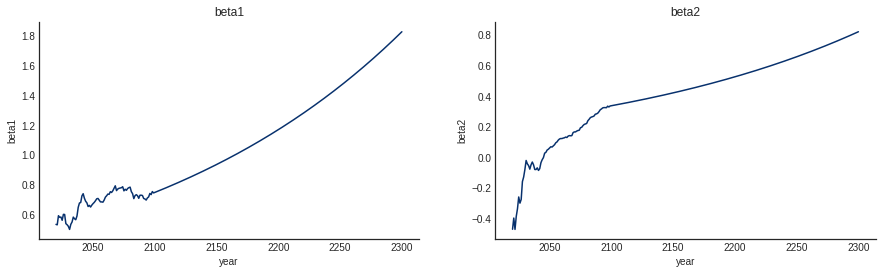

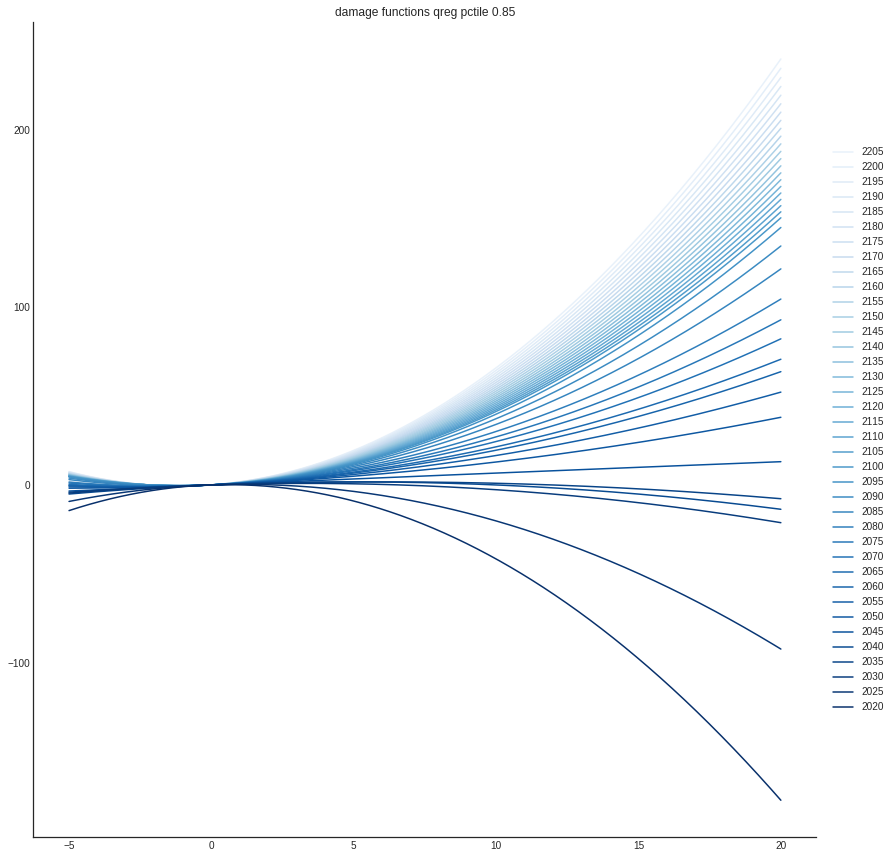

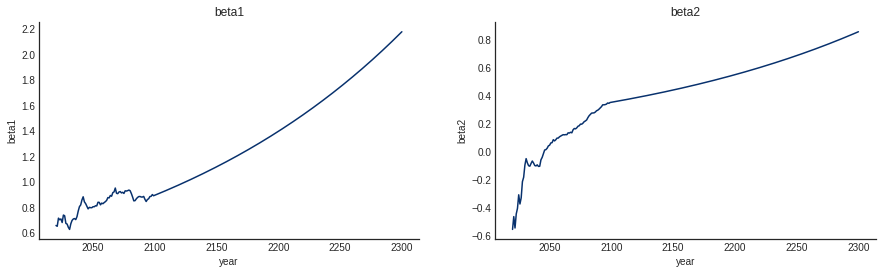

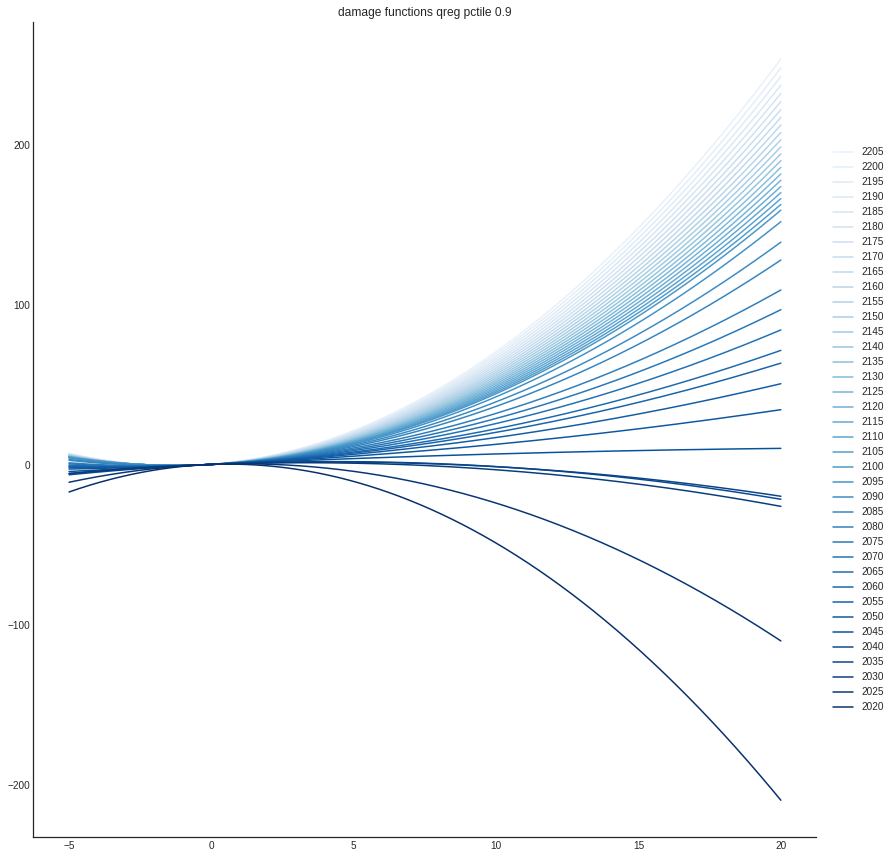

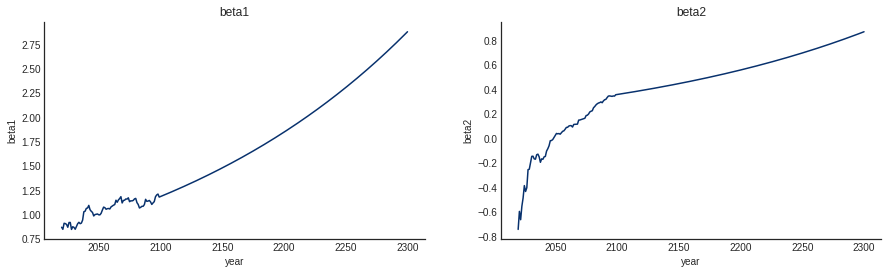

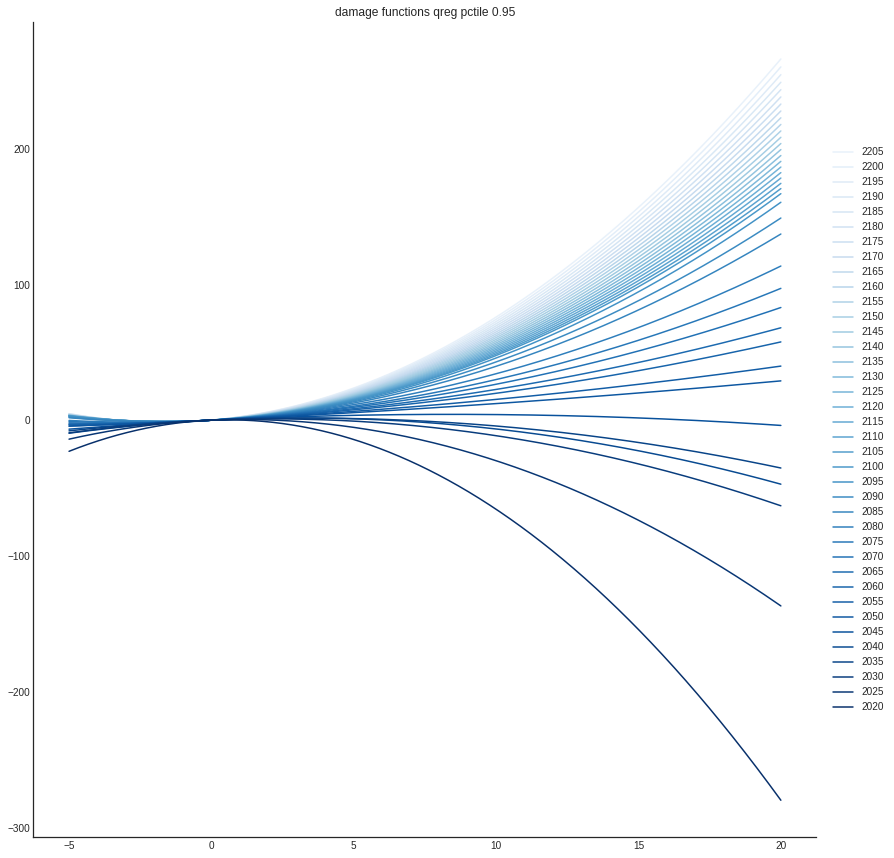

In [84]:
version = 'v0.3'

# change stuff here #
specification = 'labor_main_model'

stem = "nocons_betas_SSP{}_qreg".format(ssp)

#######################

MAGNITUDE_OF_DAMAGES = 1000000000000  # magnitude of damage function values
DAMAGES_DEFLATOR = 90.8776 # Damages based year is 2005, with this World Bank US GDP deflator
PULSE_DEFLATOR = 108.6850 # Update for the pulse base year (currently 2020) -- use the World Bank US GDP deflator for that year.
BASE_YEAR_CONVERSION = 1
# PULSE_DEFLATOR / DAMAGES_DEFLATOR  # Converts from Damages_year $ to Pulse_year $

# Toggle to generate plots or not
generate_plots = True

# Run options: which damages scenario to run, and whether or not to hold the post-2099 damage function constant.
# scenario_to_run = 'peakprice014'  # 'price0', 'price014', 'price03', 'price05', 'peakprice014'
hold_2099_damages_fixed = False
damage_func_form = df # 'quadratic' or 'cubic'

import os, glob

# Time the SCC calculation
startTime = datetime.now()

# Make sure the 'year' and 'growth_rate' columns are the first two columns in the damage function .csv
fps = glob.glob('{}/{}.csv'.format(INPUT_path,stem))

def read_damage_func(fp, pp):
    data = pd.read_csv(fps[0], index_col = [1]) 
    data = data[data.pctile == pp]
    data = data[["beta1","beta2"]]
    data.columns.names = ['coeff']
    return data.stack('coeff').to_xarray()

# pctile_list = np.arange(0.05, 0.95, 0.05)

# somehow the list above doesn't work directly....
for pp in [0.05, 0.10, 0.15, 0.2, 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9, 0.95 ]:
    ds = xr.Dataset({
        os.path.splitext(os.path.basename(fp))[0]: read_damage_func(fp, pp) for fp in fps
    })

    ####### Change stuff here to deal with placeholders
    coeffs_all_years = (
        ds.to_array(dim='variable').to_series().unstack('year')
        .reindex(list(range(2020, 2301)), axis=1)
        .stack('year')
        .unstack('coeff')
        .to_xarray()
    )
    ###########################

    # The following operation reorders the 'variable' and 'year' coordinates. This causes errors when plotting.
    # I can't get it to not do that here, but I fix it when damages are calculated below with a transpose() call.
    if hold_2099_damages_fixed:
        mask = coeffs_all_years['year'] > 2099
        coeffs_2099 = coeffs_all_years.sel(year=2099)
        coeffs_all_years = xr.where(mask, coeffs_2099, coeffs_all_years)


    coeffs_all_years = coeffs_all_years.sel(variable=stem)
    # Potential change spot!!!!
    # Growth_rate is the energy price scenario -- change for given sector's needs

    if generate_plots:
        fig, axes = plt.subplots(1, 2, figsize=(15, 4))

        for i, coeff in enumerate(['beta1', 'beta2']):
            lines = coeffs_all_years[coeff].plot.line(
                x='year', ax=axes[i], add_legend=False, 
                color=matplotlib.cm.Blues_r(1) )
            axes[i].set_title(coeff)

        sns.despine()

    powers = xr.DataArray(
            np.arange(0, 11),
            dims=['coeff'],
            coords=[['cons'] + ['beta{}'.format(i) for i in range(1, 11)]])

    # Potential change spot!!!!
    # Growth_rate is the energy price scenario -- change for given sector's needs

    if generate_plots:
        temps = np.linspace(-5, 20, 1101)
        temps = xr.DataArray(temps, dims=['temp'], coords=[temps])

        numvars = 1
        fig, axes = plt.subplots((numvars+1)//2, min(2, numvars), figsize=(15, 15))

        if numvars == 1:
            axes = np.array([[axes]])

        # dot product of coeffs and powers of temp
        spaghetti = (
            (coeffs_all_years.to_array('coeff') * (temps ** powers)).sum(dim='coeff'))

        lines = []
        for y in reversed(coeffs_all_years.year.values[:186:5]):
            lines.append(
                axes[0,0].plot(
                    temps.values,
                    spaghetti.sel(year=y).values,
                    color=matplotlib.cm.Blues_r((y-2020.0)/(2200-2000)),
                    label=int(y)))

        axes[0,0].set_facecolor('white')
        axes[0,0].set_title("damage functions qreg pctile {}".format(pp))

        plt.subplots_adjust(right=0.85)
        axes[0, -1].legend(
            list(reversed(lines))[::5],
            labels=list(reversed(coeffs_all_years.year.values[:186]))[::5],
            loc='center left',
            bbox_to_anchor=(1.01, (1-(((numvars-1)//2)%2))*0.5))
        fig.set_facecolor('white')

        sns.despine()
        fig.savefig('{}/damage_functions_{}_{}_{}_2200-fixed-{}_pctile-{}.pdf'.format(OUTPUT_path, specification, version, damage_func_form, hold_2099_damages_fixed, pp))
